The Python chess library was utilized for the implementation of the chess game. The standout feature of this library for this project lies in its legal move generation and evaluation, proving highly beneficial for generating all possible subsequent board states.

For the implementation of the Predictive Search, the scikit library was employed, specifically utilizing a specific type of Regressor: the Multi-Layer Perceptron Regressor, a neural network that can consist of multiple hidden layers. The Regressor was employed to return the optimal score achievable by the children of a given board configuration, delving deep into the search for the best obtainable score.

# Implementation:
The min-max search algorithm with alpha-beta pruning was implemented. The heuristic takes into account that chess is a zero-sum game, and in this implementation, a board with a positive heuristic favors white (while a negative heuristic favors black). This implies that white plays the role of the maximizing player, whereas black is the minimizing player in the evaluations performed during the min-max search with alpha-beta pruning.

In [1]:
import chess, chess.svg, chess.engine
import random
import time
import pandas as pd
from tqdm import tqdm
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pickle

import warnings
warnings.filterwarnings("ignore")

## Heuristics:
* **PiecesNumberHeuristic**: This heuristic evaluates solely the number of pieces remaining on the board after a move. All the counts of white pieces are assessed alongside the black ones and combined in a linear fashion.

* **PositionHeuristic**: This heuristic assesses only the position of pieces on the board. Each piece has a specific table that defines its preferred section of the board to move on.

* **evaluate_board**: This heuristic combines the evaluations of the previous two heuristics and checks whether the game has concluded (either through checkmate or a draw).

The heuristic system is divided into two parts:
**Heuristic**: This serves as the superclass for heuristic evaluation, utilized by agents.

**HeuristicChess**: Specifically tailored for chess games, this heuristic evaluates the board, i.e., the arrangement of pieces on the board.


In [2]:
"""SuperClass"""
class Heuristic:

    def __init__(self):
        pass

"""Class that implementt the heuristic evaluation of the state"""
class HeuristicChess(Heuristic):

    def __init__(self):
        pass
    
    @staticmethod
    def check_status_heuristic(board_state: chess.Board):
    

        if (
            board_state.is_stalemate()
            or board_state.is_insufficient_material()
            or board_state.is_seventyfive_moves()
            or board_state.is_fivefold_repetition()
        ):
            return 0
    
        if board_state.is_checkmate():
            if board_state.turn:
                return 9999  # black wins
            else:
                return -9999  # white wins
    
        if board_state.is_check():
            return 100 if board_state.turn else -100

        return 0

    @staticmethod
    def PiecesNumberHeuristic(board: chess.Board):
   

        wp = len(board.pieces(chess.PAWN, chess.WHITE))
        bp = len(board.pieces(chess.PAWN, chess.BLACK))
        wn = len(board.pieces(chess.KNIGHT, chess.WHITE))
        bn = len(board.pieces(chess.KNIGHT, chess.BLACK))
        wb = len(board.pieces(chess.BISHOP, chess.WHITE))
        bb = len(board.pieces(chess.BISHOP, chess.BLACK))
        wr = len(board.pieces(chess.ROOK, chess.WHITE))
        br = len(board.pieces(chess.ROOK, chess.BLACK))
        wq = len(board.pieces(chess.QUEEN, chess.WHITE))
        bq = len(board.pieces(chess.QUEEN, chess.BLACK))

        return 100 * (wp - bp) + 320 * (wn - bn) + 330 * (wb - bb) + 500 * (wr - br) + 900 * (wq - bq)

    @staticmethod
    def PositionHeuristic(board: chess.Board):

        pawntable = [
            0, 0, 0, 0, 0, 0, 0, 0,
            5, 10, 10, -20, -20, 10, 10, 5,
            5, -5, -10, 0, 0, -10, -5, 5,
            0, 0, 0, 20, 20, 0, 0, 0,
            5, 5, 10, 25, 25, 10, 5, 5,
            10, 10, 20, 30, 30, 20, 10, 10,
            50, 50, 50, 50, 50, 50, 50, 50,
            0, 0, 0, 0, 0, 0, 0, 0]

        knightstable = [
            -50, -40, -30, -30, -30, -30, -40, -50,
            -40, -20, 0, 5, 5, 0, -20, -40,
            -30, 5, 10, 15, 15, 10, 5, -30,
            -30, 0, 15, 20, 20, 15, 0, -30,
            -30, 5, 15, 20, 20, 15, 5, -30,
            -30, 0, 10, 15, 15, 10, 0, -30,
            -40, -20, 0, 0, 0, 0, -20, -40,
            -50, -40, -30, -30, -30, -30, -40, -50]

        bishopstable = [
            -20, -10, -10, -10, -10, -10, -10, -20,
            -10, 5, 0, 0, 0, 0, 5, -10,
            -10, 10, 10, 10, 10, 10, 10, -10,
            -10, 0, 10, 10, 10, 10, 0, -10,
            -10, 5, 5, 10, 10, 5, 5, -10,
            -10, 0, 5, 10, 10, 5, 0, -10,
            -10, 0, 0, 0, 0, 0, 0, -10,
            -20, -10, -10, -10, -10, -10, -10, -20]

        rookstable = [
            0, 0, 0, 5, 5, 0, 0, 0,
            -5, 0, 0, 0, 0, 0, 0, -5,
            -5, 0, 0, 0, 0, 0, 0, -5,
            -5, 0, 0, 0, 0, 0, 0, -5,
            -5, 0, 0, 0, 0, 0, 0, -5,
            -5, 0, 0, 0, 0, 0, 0, -5,
            5, 10, 10, 10, 10, 10, 10, 5,
            0, 0, 0, 0, 0, 0, 0, 0]

        queenstable = [
            -20, -10, -10, -5, -5, -10, -10, -20,
            -10, 0, 0, 0, 0, 0, 0, -10,
            -10, 5, 5, 5, 5, 5, 0, -10,
            0, 0, 5, 5, 5, 5, 0, -5,
            -5, 0, 5, 5, 5, 5, 0, -5,
            -10, 0, 5, 5, 5, 5, 0, -10,
            -10, 0, 0, 0, 0, 0, 0, -10,
            -20, -10, -10, -5, -5, -10, -10, -20]

        kingstable = [
            20, 30, 10, 0, 0, 10, 30, 20,
            20, 20, 0, 0, 0, 0, 20, 20,
            -10, -20, -20, -20, -20, -20, -20, -10,
            -20, -30, -30, -40, -40, -30, -30, -20,
            -30, -40, -40, -50, -50, -40, -40, -30,
            -30, -40, -40, -50, -50, -40, -40, -30,
            -30, -40, -40, -50, -50, -40, -40, -30,
            -30, -40, -40, -50, -50, -40, -40, -30]

        pawnsq = sum([pawntable[i] for i in board.pieces(chess.PAWN, chess.WHITE)])
        pawnsq = pawnsq + sum([-pawntable[chess.square_mirror(i)]
                               for i in board.pieces(chess.PAWN, chess.BLACK)])
        knightsq = sum([knightstable[i] for i in board.pieces(chess.KNIGHT, chess.WHITE)])
        knightsq = knightsq + sum([-knightstable[chess.square_mirror(i)]
                                   for i in board.pieces(chess.KNIGHT, chess.BLACK)])
        bishopsq = sum([bishopstable[i] for i in board.pieces(chess.BISHOP, chess.WHITE)])
        bishopsq = bishopsq + sum([-bishopstable[chess.square_mirror(i)]
                                   for i in board.pieces(chess.BISHOP, chess.BLACK)])
        rooksq = sum([rookstable[i] for i in board.pieces(chess.ROOK, chess.WHITE)])
        rooksq = rooksq + sum([-rookstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.ROOK, chess.BLACK)])
        queensq = sum([queenstable[i] for i in board.pieces(chess.QUEEN, chess.WHITE)])
        queensq = queensq + sum([-queenstable[chess.square_mirror(i)]
                                 for i in board.pieces(chess.QUEEN, chess.BLACK)])
        kingsq = sum([kingstable[i] for i in board.pieces(chess.KING, chess.WHITE)])
        kingsq = kingsq + sum([-kingstable[chess.square_mirror(i)]
                               for i in board.pieces(chess.KING, chess.BLACK)])

        return pawnsq + knightsq + bishopsq + rooksq + queensq + kingsq

    def evaluate_board(self, board: chess.Board):
        """
        Evaluate the overall heuristic value of the chess board.

        Args:
        - board (chess.Board): The current state of the chess board.

        Returns:
        - int: Overall heuristic value.
        """

        if board.is_stalemate():
            if board.turn:
                return 5000
            else:
                return -5000

        if board.is_checkmate():
            if board.turn:
                return -9999
            else:
                return 9999

        npieces = self.PiecesNumberHeuristic(board)
        ppieces = self.PositionHeuristic(board)

        eval = npieces + ppieces

        if board.turn:
            return eval
        else:
            return -eval


## Agent:
* **Using Greedy Algorithm**: This agent employs a Greedy algorithm, making decisions based on the locally optimal choice at each stage without considering the global picture.

* **Using Min-Max with Alpha-Beta Pruning**: This agent utilizes the Min-Max algorithm with Alpha-Beta pruning, a systematic approach for decision-making in two-player games, considering the best and worst-case scenarios.

* **Using Min-Max with Alpha-Beta Pruning for Adaptive Search**: This agent extends the Alpha-Beta pruning approach with an Adaptive Search strategy. It explores the subtrees of only the k most promising nodes at level l, tailoring the search to focus on the most relevant areas of the decision tree.

In [3]:
class Agent:
    def __init__(self, player: str, solver):
        """
        Initialize the Agent.
        This Class rapresentt an agent that can apply different solution search strategies.

        Parameters:
        - player: The player identifier (e.g., 'WHITE' or 'BLACK').
        - solver: The solver or strategy used by the agent.
        """

        self.player = player
        self.solver = solver

class GreedyPlayer(Agent):
    def __init__(self, player, solver: Heuristic):


        super().__init__(player, solver)

    def move(self, board) -> str:


        moves = list(board.legal_moves)

        for move in moves:
            test_board = board.copy()
            test_board.push(move)

            move.score = self.solver.evaluate_board(test_board)

        #print("GREEDY", moves[0])
        return moves[0]

class MinMaxPlayer(Agent):
    def __init__(self, player, solver: Heuristic, depth):


        super().__init__(player, solver)
        self.depth = depth

    def move(self, board):


        bestMove = chess.Move.null()
        bestValue = -99999
        alpha = -100000
        beta = 100000
        depth = self.depth
        for move in board.legal_moves:
            board.push(move)
            boardValue = -self.minMax(board, -beta, -alpha, depth - 1)
            if boardValue > bestValue:
                bestValue = boardValue
                bestMove = move
            if boardValue > alpha:
                alpha = boardValue
            board.pop()
        return bestMove

    def minMax(self, board, alpha, beta, depthleft):

        bestscore = -9999
        if (depthleft == 0):
            return self.solver.evaluate_board(board)
        else:
            for move in board.legal_moves:
                board.push(move)
                score = -self.minMax(board, -beta, -alpha, depthleft - 1)
                board.pop()
                if (score >= beta):
                    return score
                if (score > bestscore):
                    bestscore = score
                if (score > alpha):
                    alpha = score
        return bestscore

class MinMaxPlayerSpeedUp(MinMaxPlayer):
    def __init__(self, player, solver: Heuristic, depth, l, k):

        super().__init__(player, solver, depth)
        self.promNodes = None
        self.depth = depth
        self.level = l
        self.best = k

        self.states = []
        self.moves = []
        self.bestValue = []
        self.pieceCount = []
        self.threatCount = []
        self.pawnStructure = []

    def move(self, board):


        bestMove = chess.Move.null()
        bestValue = -99999
        alpha = -100000
        beta = 100000
        depth = self.depth
        self.promNodes = []
        for move in board.legal_moves:
            board.push(move)
            boardValue = -self.minMaxAdapt(board, -beta, -alpha, depth - 1)
            if boardValue > bestValue:
                bestValue = boardValue
                bestMove = move
            if boardValue > alpha:
                alpha = boardValue
            board.pop()

        # observations
        self.states.append(board.board_fen())
        self.bestValue.append(bestValue)
        self.moves.append(bestMove)
        self.pieceCount.append(len(board.piece_map()))
        self.threatCount.append(len(board.attackers(not board.turn, board.king(not board.turn))))
        self.pawnStructure.append(sum(1 for square in chess.SquareSet(board.pawns) if board.is_pinned(not board.turn, square)))
        #print("MINMAX", bestMove)

        return bestMove

    def minMaxAdapt(self, board, alpha, beta, depthleft):

        bestscore = -9999
        eval = True
        if depthleft == 0:
            return self.solver.evaluate_board(board)
        else:
            for move in board.legal_moves:
                board.push(move)
                if depthleft == self.level:
                    x = self.solver.evaluate_board(board)
                    self.promNodes.append(x)
                    self.promNodes.sort()
                    if self.promNodes.__len__() >= self.best:
                        if (x in self.promNodes[self.promNodes.__len__() - self.best - 1:self.promNodes.__len__() - 1]):
                            eval = False
                            bestscore = 100001
                if (eval):
                    score = -self.minMaxAdapt(board, -beta, -alpha, depthleft - 1)
                    board.pop()
                    if (score >= beta):
                        return score
                    if (score > bestscore):
                        bestscore = score
                    if (score > alpha):
                        alpha = score
                else:
                    board.pop()
        return bestscore

## Game class divided into Superclass for games played by agents and a Chess class for game

In [4]:
class Game:
    def __init__(self, A1, A2, Board):
    
        self.player1 = A1
        self.player2 = A2
        self.board = Board
        self.history = []

class Chess:
    def __init__(self, A1, A2,  Board):


        self.player1 = A1
        self.player2 = A2
        self.board = Board
        self.history = []

    def Begin(self):
  

        self.board = chess.Board()
        turns = random.randint(1, 9)
        for x in range(turns):
            moves = list(self.board.legal_moves)
            move = random.choice(moves).uci()
            self.board.push_uci(move)


    def Play(self):

        try:
            i = 0
            while not self.board.is_game_over(claim_draw=True):
                if self.board.turn:
                   move = self.player1.move(self.board)
                else:
                   move = self.player2.move(self.board)

                i += 1
                self.board.push(move)
                self.history.append(move)

        except KeyboardInterrupt:
            exit(1)

        return i, str(self.board.result())
    
    def startGame(self):
        """
        Start the chess game by initializing and playing.

        Returns:
        - Result of the game after playing.
        """

        self.Begin()
        return self.Play()

# Predictive Agent

The PredictivePlayer class has been developed to leverage the predict_move method instead of the traditional move function employed by the MinMax algorithm using heuristics. Rather than modifying an existing class, a new agent, named *PredictivePlayer*, has been created.

Unlike traditional agents relying on heuristic functions, the PredictivePlayer class focuses on state prediction based on a combination of factors such as *fen* (Forsyth–Edwards Notation), *BestMove*, *PieceCount*, *ThreatCount*, and *PawnStructure*. These factors are utilized in accordance with a dataset to make predictions about the game state, showcasing a departure from the heuristic-driven approach commonly seen in MinMax-based agents.

In [13]:
class PredictivePlayer(Agent):
    def __init__(self, player, regressor):
    
        super().__init__(player, None)
        self.regressor = regressor
        
        self.features_updated = False
        
        self.map = {
            '0': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'p': 6,
            'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11, 'P': 12
        }
        #self.moves = []
        self.pieceCount = []
        self.threatCount = []
        self.pawnStructure = []
        
    def split(self, string):
        return [char for char in string] 
    
    def toZeroes(self, string):
        return ''.join([char if not char.isdigit() else '0' * int(char) for char in string])
    
    def predictedValue(self, board):


        if not self.features_updated:
            self.update_features(board)
            self.features_updated = True
    
        actual_board = np.array(self.split(self.toZeroes(board.board_fen()).replace('/', '')))
        mapped_board = np.vectorize(self.map.get)(actual_board)
        
        all_features = np.concatenate([
            mapped_board.reshape(1, -1),
            #np.array(self.moves).reshape(1, -1),
            np.array(self.pieceCount).reshape(1, -1),
            np.array(self.threatCount).reshape(1, -1),
            np.array(self.pawnStructure).reshape(1, -1)
        ], axis=1)

        return self.regressor.predict(all_features.reshape(1, -1))
    
    def update_features(self, board):


        #self.moves.append(board.san(self.move(board)))
        self.pieceCount.append(len(board.piece_map()))
        self.threatCount.append(len(board.attackers(not board.turn, board.king(not board.turn))))
        self.pawnStructure.append(sum(1 for square in chess.SquareSet(board.pawns) if board.is_pinned(not board.turn, square)))
    
    def move(self, board):
  
        self.features_updated = False  # Resetting flag
        return super().move(board)


class PredictivePlayerGreedy(PredictivePlayer):
  

    def __init__(self, player, regressor):
        super().__init__(player, regressor)
        self.solver = None
        
    def move(self, board) -> str:
        moves = list(board.legal_moves)

        for move in moves:
            test_board = board.copy()
            test_board.push(move)
            move.score = self.predictedValue(board)

        return moves[0]
        
class PredictivePlayerMinMax(PredictivePlayer):
    """
    MinMax variant of PredictivePlayer that selects the move maximizing the predicted value.
    """

    def __init__(self, player, depth, regressor):
        super().__init__(player, regressor)
        self.solver = None
        self.depth = depth
        
    
    def move(self, board):
        legal_moves = list(board.legal_moves)
        if legal_moves:
            bestMove = legal_moves[0]
        else:
            bestMove = chess.Move.null()
    
        bestValue = -99999
        alpha = -100000
        beta = 100000
        depth = self.depth
    
        for move in legal_moves:
            board.push(move)
            boardValue = -self.minMax(board, -beta, -alpha, depth - 1)
    
            if boardValue > bestValue:
                bestValue = boardValue
                bestMove = move
    
            if boardValue > alpha:
                alpha = boardValue
    
            board.pop()
    
        #print("PREDICTIVE", bestMove)
        return bestMove

    def minMax(self, board, alpha, beta, depthleft):
        bestscore = -9999
        if (depthleft == 0):
            return self.predictedValue(board)
        else:
            for move in board.legal_moves:
                board.push(move)
                score = -self.minMax(board, -beta, -alpha, depthleft - 1)
                board.pop()
                if (score >= beta):
                    return score
                if (score > bestscore):
                    bestscore = score
                if (score > alpha):
                    alpha = score
        return bestscore

## Dataset creation through 1000 games at depth 5

In [ ]:
ds = []
iters = 1000

print(f"\nNumber of games: {iters}"); print()

# Dtasets entries
ds = {'FEN': [], 'BestMove': [], 'PieceCount': [], 'ThreatCount': [], 'PawnStructure': [], 'Score': []}

for _ in tqdm(range(iters), desc="Gaming", unit="iter"):
    H = HeuristicChess()
    Agent1 = MinMaxPlayerSpeedUp("WHITE", H, depth=5, l=3, k=8)
    Agent2 = GreedyPlayer("BLACK", H)

    Game = Chess(Agent1, Agent2, chess.Board())
    Game.Begin()
    game_result = Game.Play()

    outcome, movesPlayed, _ = game_result

    states = Agent1.states
    moves = Agent1.moves
    pieceCount = Agent1.pieceCount
    threatCount = Agent1.threatCount
    pawnStructure = Agent1.pawnStructure
    scores = Agent1.bestValue

    for i in range(len(states)):
        ds['FEN'].append(states[i])
        ds['BestMove'].append(moves[i])
        ds['PieceCount'].append(pieceCount[i])
        ds['ThreatCount'].append(threatCount[i])
        ds['PawnStructure'].append(pawnStructure[i])
        ds['Score'].append(scores[i])

ds = pd.DataFrame(ds)

filename = "regressor.sav"
directory = "./better_dataset/"
ds.to_csv(directory + filename, index=False) # exporting dataset

## Testing code cell

In [ ]:
iters = 5
depths = range(1, 4)
l_values = range(1,4)

for depth, l in product(depths, l_values):
    white_wins = 0
    black_wins = 0
    draws = 0
        
    print(f"\nNumber of games: {iters}"); print()
    print(f'White with depth MinMax {depth} and l {l}')
    print(f'Black with Greedy')

    for _ in tqdm(range(iters), desc="Gaming", unit="iter"):
            
        H = HeuristicChess()
        Agent1 = MinMaxPlayerSpeedUp("WHITE", H, depth=depth, l=l, k=5)
        Agent2 = GreedyPlayer("BLACK", H)
            
        Game = Chess(Agent1, Agent2, chess.Board())
        Game.Begin()
        game_result = Game.Play()

        moves, _ = game_result
            
        if game_result[1] == "1-0":
            white_wins += 1
        elif game_result[1] == "0-1":
            black_wins += 1
        else:
            draws += 1
        
    print()
    print(f'White victories: {white_wins}')
    print(f'Black victories: {black_wins}')
    print(f'Draws: {draws}')
    print(); print()
    print('-' * 80); print()

## Once the dataset with the observations is saved, we process it in a way that allows us to feed it to the regressor.

In [6]:
ds = pd.read_csv("./better_dataset/dataset.csv")
ds

,FEN,BestMove,PieceCount,ThreatCount,PawnStructure,Score
0,rnb1kbnr/ppqpp1p1/2p2pNp/8/P7/8/1PPPPPPP/RNBQKB1R,b1c3,32,0,0,415
1,rnb1kbnr/p1qpp1p1/1pp2pNp/8/P7/2N5/1PPPPPPP/R1...,e2e4,32,0,0,470
2,rnb1kbn1/p1qpp1pr/1pp2pNp/8/P3P3/2N5/1PPP1PPP/...,d2d4,32,0,0,470
3,rnbqkbn1/p2pp1pr/1pp2pNp/8/P2PP3/2N5/1PP2PPP/R...,f1c4,32,1,0,495
4,rnbqkbn1/p2pp1pr/1pp2pN1/7p/P1BPP3/2N5/1PP2PPP...,c4g8,32,1,0,955
...,...,...,...,...,...,...
16430,1nbq2n1/r2pp2r/1Pp2ppb/p1k4p/4P3/1QNB1N2/PP1P1...,c3a4,31,0,0,870
16431,1nbq2n1/r2pp2r/1Ppk1ppb/p6p/N3P3/1Q1B1N2/PP1P1...,b3a3,31,1,0,845
16432,1nbq2n1/r2pp2r/1Pp1kppb/p6p/N3P3/Q2B1N2/PP1P1P...,a4c5,31,1,0,880
16433,1nbq2n1/r2pp2r/1Ppk1ppb/p1N4p/4P3/Q2B1N2/PP1P1...,c5b7,31,1,0,865


In [7]:

    
    class ChessDatasetProcessor:
    def __init__(self, dataset: pd.DataFrame):
     
        self.dataset = dataset
        
        self.chess_move_mapping = {
            'a1': 0, 'a2': 1, 'a3': 2, 'a4': 3, 'a5': 4, 'a6': 5, 'a7': 6, 'a8': 7,
            'b1': 8, 'b2': 9, 'b3': 10, 'b4': 11, 'b5': 12, 'b6': 13, 'b7': 14, 'b8': 15,
            'c1': 16, 'c2': 17, 'c3': 18, 'c4': 19, 'c5': 20, 'c6': 21, 'c7': 22, 'c8': 23,
            'd1': 24, 'd2': 25, 'd3': 26, 'd4': 27, 'd5': 28, 'd6': 29, 'd7': 30, 'd8': 31,
            'e1': 32, 'e2': 33, 'e3': 34, 'e4': 35, 'e5': 36, 'e6': 37, 'e7': 38, 'e8': 39,
            'f1': 40, 'f2': 41, 'f3': 42, 'f4': 43, 'f5': 44, 'f6': 45, 'f7': 46, 'f8': 47,
            'g1': 48, 'g2': 49, 'g3': 50, 'g4': 51, 'g5': 52, 'g6': 53, 'g7': 54, 'g8': 55,
            'h1': 56, 'h2': 57, 'h3': 58, 'h4': 59, 'h5': 60, 'h6': 61, 'h7': 62, 'h8': 63
        }
        
        self.piece_mapping = {
            '0': 0, 'r': 1, 'n': 2, 'b': 3, 'q': 4, 'k': 5, 'p': 6,
            'R': 7, 'N': 8, 'B': 9, 'Q': 10, 'K': 11, 'P': 12
        }
    

    @staticmethod
    def toZeroes(string):


        string = string.split(' ')[0]
        for i in string.split('/'):
            for j in i:
                if(j.isdigit()):
                    string=string.replace(j,'0'*int(j))
        return string
    
    @staticmethod
    def split(string):
    

        return [char for char in string]    
    
    def convertPieces(self):
        columns_to_map = [col for col in self.dataset.columns if col != 'Score']
    
        for col in columns_to_map:
            self.dataset[col] = self.dataset[col].map(self.piece_mapping)
    
    def convert_move(self, move):
        try:
            start_square = str(self.chess_move_mapping.get(move[:2], move[:2]))
            end_square = str(self.chess_move_mapping.get(move[2:4], move[2:4]))
    
            # Se è una promozione, aggiungi il carattere di promozione
            if len(move) > 4 and move[4].isalpha():
                promotion_piece = move[4:].lower()
                # Mappa la parte di promozione
                promotion_piece = str(self.piece_mapping.get(promotion_piece, promotion_piece))
                end_square += promotion_piece
    
            return start_square + end_square
        except Exception as e:
            print(f"Errore durante la conversione della mossa {move}: {e}")
            return None  # o gestisci l'errore nel modo che preferisci
    
    def convert_to_float(self, value):
        """
        Convert a value to a float.

        Parameters:
        - value: The input value.

        Returns:
        - The converted float value.
        """

        try:
            return float(value[1:]) if '#' in str(value) else float(value)
        except ValueError:
            return None
    
    def process_dataset(self):
        """
        Process the chess dataset.

        Returns:
        - The processed dataset.
        """

        array_fen = self.dataset['FEN'].tolist()
        array_move = self.dataset['BestMove'].tolist()
        array_piece = self.dataset['PieceCount'].tolist()
        array_threat_count = self.dataset['ThreatCount'].tolist()
        array_pawn = self.dataset['PawnStructure'].tolist()
        array_scores = self.dataset['Score'].tolist()
        
        tqdm_iterator = tqdm(enumerate(array_fen), total=len(array_fen), desc="Processing DataFrame")
        
        # Create a DataFrame with separate columns for each position
        df_positions = pd.DataFrame([self.split(self.toZeroes(fen).replace('/', '')) for _, fen in tqdm_iterator],
                                    columns=[f'{i}' for i in range((8 * 8))])
        
        processed_dataset = pd.concat([
            df_positions,
            pd.Series(array_move, name="BestMove"),
            pd.Series(array_piece, name="PieceCount"),
            pd.Series(array_threat_count, name="ThreatCount"),
            pd.Series(array_pawn, name="PawnStructure"),
            pd.Series(array_scores, name='Score')
        ], axis=1)
        
        processed_dataset = processed_dataset.replace({col: self.piece_mapping for col in processed_dataset.columns})

        self.convertPieces()
       
        processed_dataset['BestMove'] = processed_dataset['BestMove'].apply(self.convert_move)
        processed_dataset['Score'] = processed_dataset['Score'].apply(self.convert_to_float)
        processed_dataset['Score'] = processed_dataset['Score'].astype(float)

        return processed_dataset

df = ChessDatasetProcessor(ds).process_dataset()

Processing DataFrame: 100%|██████████| 16435/16435 [00:20<00:00, 810.99it/s] 


## Create and train a Multi-Layer Perceptron (MLP) regression model using scikit-learn's 'MLPRegressor'

It perform a training using 2 hidden layer of 300 neurons after dividing the data into training and testing sets using the train_test_split using 20% of data for testing.

In [ ]:

y = df['Score']  # target Score
X = df.drop(columns=['Score'])  # input features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

mlp = MLPRegressor(hidden_layer_sizes=(300, 300,), max_iter=200, verbose=True)
fitting = mlp.fit(X_train, y_train)

## Plotting results of mlp training

As we can see

In [22]:
print("Training set score: ",mlp.score(X_train,y_train))
print("Test set score: ",mlp.score(X_test,y_test))

Training set score:  0.8664158836706483
Test set score:  0.4007507880734168


## Saving regressor object

In [9]:
filename = "model.sav"
directory = "./dataset/"
df.to_csv(directory + filename, index=False)

pickle.dump(mlp, open(directory + filename, 'wb'))
mlp = pickle.load(open(directory + filename, 'rb'))

## Main class for testing model

It will show statistics about games in different cases of studies.

In [15]:
class Main:
    def __init__(self, player1 , player2, game, matches, view=False):
    

        self.player1 = player1
        self.player2 = player2
        self.game = game
        self.matches = matches
        self.view = view
        
    def play(self):
    
        WW = 0
        WB = 0
        P = 0
        mosseTot = 0
        st = time.time()
        
        for _ in tqdm(range(1, self.matches), desc="Gaming", unit="iter"):
            a = self.game.startGame()
            mosseTot += a[0]

            if a[1] == "1-0":
               if self.view: print("White win")
               WW += 1
               
            elif a[1] == "0-1":
                if self.view: print("Black win")
                WB += 1
            else: # * = draw
                P += 1
                if self.view: print("Draw")
            
            if self.view: print("Moves Made:" + str(a[0])); print()
            
            if (_ == (self.matches - 1) and self.view):
                print();print("-" * 80)
        
        et = time.time()
        elapsed_time = et - st
        
        print("WHITE Player Wins: " + str(WW))
        print("BLACK Player Wins: " + str(WB))
        print("Draws: " + str(P)); print()
        print("Total Moves: " + str(mosseTot))
        print("Average Number of Moves per Game: " + str(round(mosseTot / (self.matches - 1), 2))); print()
        print("WHITE Player Win Percentage: " + str(round(WW / (self.matches - 1) * 100, 2)) + "%")
        print("BLACK Player Win Percentage: " + str(round(WB / (self.matches - 1) * 100, 2)) + "%")
        print("Draw Percentage: " + str(round(P / (self.matches - 1) * 100, 2)) + "%")
        print("-" * 80)
        print('Execution time:', round(elapsed_time, 2), 'seconds')
        print(round(elapsed_time/(rep - 1), 2), 'seconds per match (average)')
        
        plot_results(WW, WB, P, self.matches - 1)

def plot_results(wins_white, wins_black, draws, matches):

    strategies = ['White Wins', 'Black Wins', 'Draws']
    percentages = [wins_white / matches * 100, wins_black / matches * 100, draws / matches * 100]

    fig, ax = plt.subplots()
    bars = ax.bar(strategies, percentages, color=['blue', 'green', 'gray'])

    ax.set_ylabel('Percentage')
    ax.set_title('Results of Chess Matches')
    
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        ax.annotate(f'{percentage:.2f}%',  # Mostra la percentuale sopra la barra
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # Spazio aggiuntivo tra la barra e l'etichetta
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.show()

rep = 100

# PredictiveMinMax and PredictiveGreedy vs different case of studies

In each scenario, a simulation is configured with 100 matches (rep) involving two players, denoted as player1 and player2. This simulation utilizes a dedicated chess game implementation (game). Subsequently, the play method is invoked to carry out the simulation, and the results of the total games are printed.

Observing the outcomes, it becomes evident that the Min-Max algorithm outperforms the Greedy approach, as the latter never secures a victory. However, the limitations of the predictor become apparent, as the win ratio is notably low; in fact, nearly all outcomes result in draws.


Gaming: 100%|██████████| 100/100 [1:14:56<00:00, 44.96s/iter]

WHITE Player Wins: 3
BLACK Player Wins: 0
Draws: 97

Total Moves: 4099
Average Number of Moves per Game: 40.99

WHITE Player Win Percentage: 3.0%
BLACK Player Win Percentage: 0.0%
Draw Percentage: 97.0%
--------------------------------------------------------------------------------
Execution time: 4496.16 seconds
44.96 seconds per match (average)


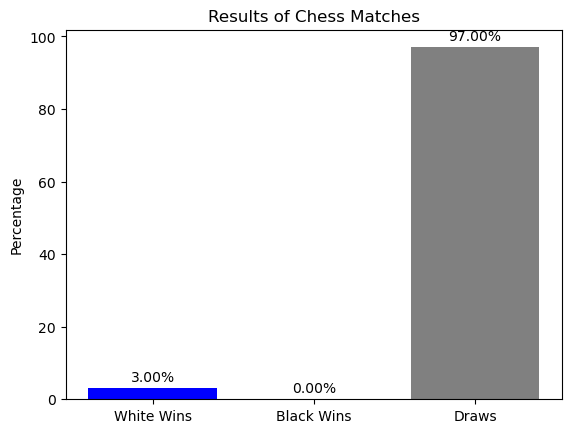

In [69]:
Agent1 = PredictivePlayerMinMax("WHITE", 3, mlp)
Agent2 = GreedyPlayer("BLACK", HeuristicChess())

Game = Chess(Agent1, Agent2, chess.Board())
main = Main(Agent1, Agent2, Game, rep)
main.play()

## Test on Predictive at Level 3 vs MinMax (Depth L):

The MinMax agent secured a slightly higher count of victories in comparison to the predictive agent. This observation could imply that, within specific configurations or the examined game dynamics, the black agent possesses a strategic advantage or is more adept at capitalizing on opportunities.

Gaming: 100%|██████████| 100/100 [1:16:01<00:00, 45.62s/iter]

WHITE Player Wins: 21
BLACK Player Wins: 28
Draws: 51

Total Moves: 4132
Average Number of Moves per Game: 41.32

WHITE Player Win Percentage: 21.0%
BLACK Player Win Percentage: 28.0%
Draw Percentage: 51.0%
--------------------------------------------------------------------------------
Execution time: 4561.65 seconds
45.62 seconds per match (average)


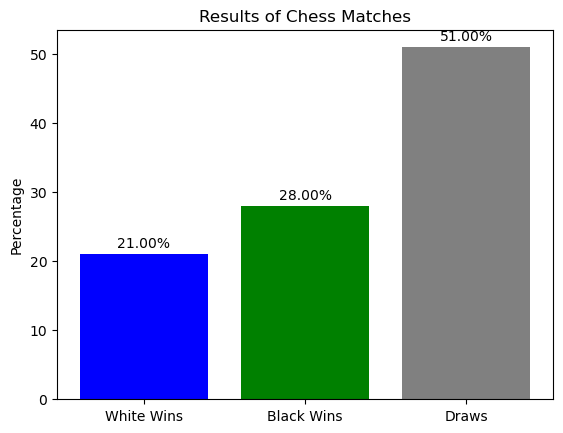

In [72]:
Agent1 = PredictivePlayerMinMax("WHITE", 3, mlp)
Agent2 = MinMaxPlayerSpeedUp("BLACK", HeuristicChess(), 3, 2, 8)

Game = Chess(Agent1, Agent2, chess.Board())
main = Main(Agent1, Agent2, Game, rep)
main.play()

## Experiments on PredictivePlayerMinMax at level 3 and PredictivePlayerGreedy

The findings from these tests indicate that, within the defined configurations or game dynamics, the MinMax strategy with pruning, implemented by the white player, demonstrates greater efficacy in making winning decisions when compared to the Greedy method employed by the black player. The absence of victories for the black player may suggest a limitation in the effectiveness of the Greedy strategy within this particular context.

Gaming: 100%|██████████| 100/100 [1:14:50<00:00, 44.91s/iter]

WHITE Player Wins: 13
BLACK Player Wins: 0
Draws: 87

Total Moves: 4087
Average Number of Moves per Game: 40.87

WHITE Player Win Percentage: 13.0%
BLACK Player Win Percentage: 0.0%
Draw Percentage: 87.0%
--------------------------------------------------------------------------------
Execution time: 4490.8 seconds
44.91 seconds per match (average)


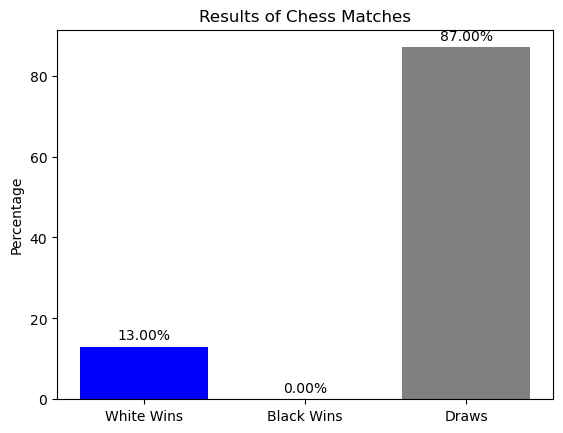

In [16]:
Agent1 = PredictivePlayerMinMax("WHITE", 3, mlp)
Agent2 = PredictivePlayerGreedy("BLACK", mlp)

Game = Chess(Agent1, Agent2, chess.Board())
main = Main(Agent1, Agent2, Game, rep)
main.play()

## Tests on PredictivePlayerGreedy and PredictivePlayerMinMax at level 3

These results suggest that, in the specific configurations or game dynamics considered, the MinMax approach adopted by the black player (MinMax) has been consistently more successful, securing a significant number of victories compared to the Greedy approach utilized by the white player (PredictivePlayerGreedy). The draws indicate a balance in some game scenarios, but the dominance of MinMax in wins implies its strategic advantage in this context.

Gaming: 100%|██████████| 100/100 [15:17<00:00,  9.18s/iter]


WHITE Player Wins: 0
BLACK Player Wins: 54
Draws: 46

Total Moves: 2855
Average Number of Moves per Game: 28.55

WHITE Player Win Percentage: 0.0%
BLACK Player Win Percentage: 54.0%
Draw Percentage: 46.0%
--------------------------------------------------------------------------------
Execution time: 917.94 seconds
9.18 seconds per match (average)


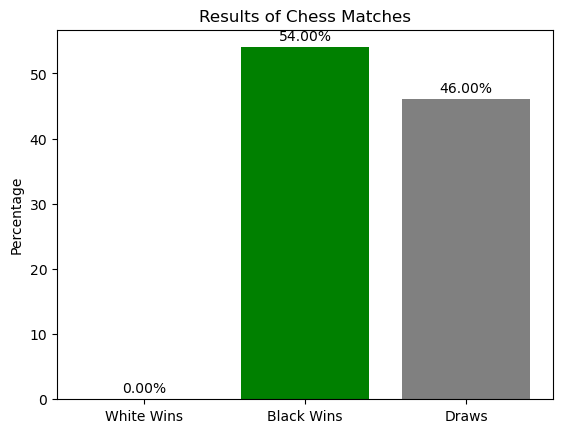

In [17]:
Agent1 = PredictivePlayerGreedy("WHITE", mlp)
Agent2 = MinMaxPlayerSpeedUp("BLACK", HeuristicChess(), 3, 2, 8)

Game = Chess(Agent1, Agent2, chess.Board())
main = Main(Agent1, Agent2, Game, rep)
main.play()